In [2]:
import numpy as np
from scipy import interpolate

import os, sys

import logging 

import matplotlib.pyplot as plt

from copy import copy

import h5py

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [3]:
from imucapture.ic_process import Ic_process
from imucapture.ic_data import Ic_data
from imucapture.ic_get_basis import Ic_get_basis

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [5]:
timescale = 1000.0

# Calibrate

In [6]:
calibdata = Ic_data()
calibdata.load_hdf5_file('/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/calib.hdf5')

DEBUG:root:datafile: /data/ KeysView(<HDF5 file "calib.hdf5" (mode r)>)


DEBUG:root:Loaded 2 IMUs


True

Plot the calibration data for the two IMUs.  One is mounted on the end of the arm, and one is on the base

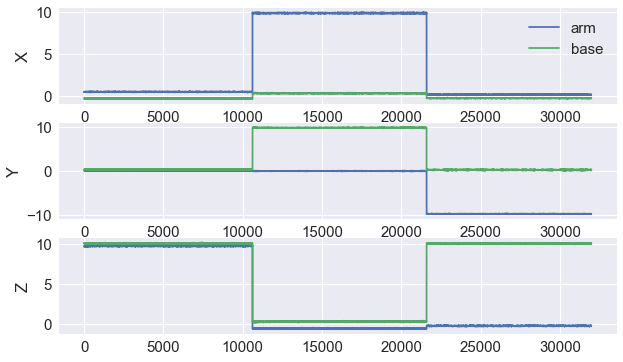

In [7]:
fig, ax = plt.subplots(3)

for acc1, gyro1, ax1 in zip(calibdata.imu_data['imus'][0]['accel'], calibdata.imu_data['imus'][0]['gyro'], ax):
    ax1.plot(np.array(calibdata.imu_data['timestamps']), 
             np.array(acc1), label='arm')

for acc1, gyro1, ax1 in zip(calibdata.imu_data['imus'][1]['accel'], calibdata.imu_data['imus'][0]['gyro'], ax):
    ax1.plot(np.array(calibdata.imu_data['timestamps']), 
             np.array(acc1), label='base')

ax[0].set_ylabel('X')
ax[1].set_ylabel('Y')
ax[2].set_ylabel('Z')
ax[0].legend()

plt.show()

We'll only do the calibration for the arm IMU, so remove the other one

In [8]:
calibdata1 = Ic_data()
calibdata1.imu_data['imus'] = calibdata.imu_data['imus'][0:1]
calibdata1.imu_data['timestamps'] = calibdata.imu_data['timestamps']
calibdata1.num_imus = 1

First look for stable intervals in the calibration data set.  There should be only three

In [9]:
get_basis = Ic_get_basis()
intervals = get_basis.get_intervals(calibdata1)

INFO:root:found 3 steady intervals:


INFO:root:[(0, 2126), (2126, 4322), (4322, 6400)]


In [10]:
basis_vector = get_basis.get_basis_vector(calibdata1, intervals)

INFO:root:found approximately orthogonal vectors:
(0.45210320323754039, 0.096765838123511347, 9.6844117031036436)
(9.8701279614113133, 0.018321748132479807, -0.5254858346852237)
(0.1083762226945509, -9.7606105851115679, -0.20365577057149054)


INFO:root:applying Gram-Schmidt


Show the basis matrix.  The columns are the chip's axes, expressed in world coordinates.

In [11]:
world_basis = np.array(basis_vector)
print(world_basis)

[[ 0.04575447  0.01030906 -0.99889952]
 [ 0.9988925   0.01050683  0.04586259]
 [ 0.01096806 -0.99989166 -0.00981691]]


So this matrix indicates that the chip is aligned with its x axis mostly along the world's y, its y axis along the world's negative z, and its z axis mostly along negative x.

The chip on the base is aligned with the world axes.

In [12]:
base_basis = np.array([[1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0],
                       [0.0, 0.0, 1.0]])

Now get the data from when the chip was still. This could be in any of the intervals in the calibration data set.  It allows us to calculate the bias and covariances in the noise

In [13]:
still_accel = np.array(calibdata1.as_list_of_triples(0, 'accel'))
still_accel = still_accel[intervals[0][0]:intervals[0][1], :]

still_gyro = np.array(calibdata1.as_list_of_triples(0, 'gyro'))
still_gyro = still_gyro[intervals[0][0]:intervals[0][1], :]

Madgwick et al (2011) say that the optimal value for their $\beta$ parameter is
$$\sqrt{3/4}\tilde{\omega}_{max}$$
where $\tilde{\omega}_{max}$ is the maximum measurement error in the gyroscope.

We use twice the standard deviation of the maximum noise channel when the gyro is sitting still.

In [15]:
beta = np.sqrt(0.75) * np.max(2*np.std(still_gyro, axis=0))
print('beta = {:.3} rad/s = {:.3} deg/s'.format(beta, np.rad2deg(beta)))

beta = 0.00391 rad/s = 0.224 deg/s


# Process test data sets

## Rotation but not translation

In [16]:
data = Ic_data()
data.load_hdf5_file('/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_only.hdf5')

DEBUG:root:datafile: /data/ KeysView(<HDF5 file "rotate_only.hdf5" (mode r)>)


DEBUG:root:Loaded 2 IMUs


True

Show the raw data

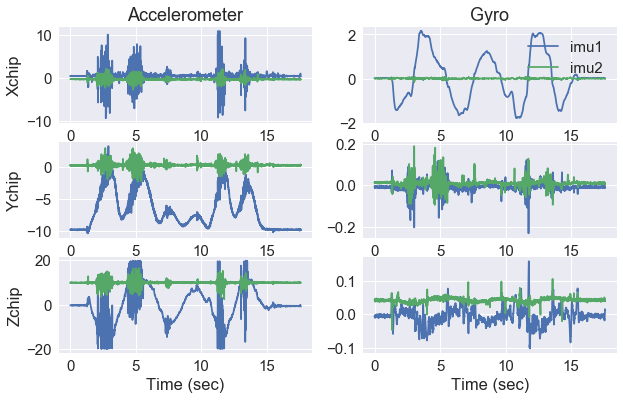

In [17]:
fig, ax = plt.subplots(3,2)

timescale = 1000.0

for acc1, gyro1, ax1 in zip(data.imu_data['imus'][0]['accel'], data.imu_data['imus'][0]['gyro'], ax):
    ax1[0].plot(np.array(data.imu_data['timestamps'])/timescale, 
             np.array(acc1), label='imu1')
    ax1[1].plot(np.array(data.imu_data['timestamps'])/timescale, 
             np.array(gyro1), label='imu1')

for acc1, gyro1, ax1 in zip(data.imu_data['imus'][1]['accel'], data.imu_data['imus'][1]['gyro'], ax):
    ax1[0].plot(np.array(data.imu_data['timestamps'])/timescale, 
             np.array(acc1), label='imu2')
    ax1[1].plot(np.array(data.imu_data['timestamps'])/timescale, 
             np.array(gyro1), label='imu2')

ax[0,1].legend(loc='upper right')
ax[0,0].set_title('Accelerometer')
ax[0,1].set_title('Gyro')
ax[0,0].set_ylabel('Xchip')
ax[1,0].set_ylabel('Ychip')
ax[2,0].set_ylabel('Zchip')

ax[2,0].set_xlabel('Time (sec)')
ax[2,1].set_xlabel('Time (sec)')

plt.show()

Get the initial orientation of the chip in this data set

In [18]:
acc = np.array(data.as_list_of_triples(0, 'accel'))
t = np.array(data.imu_data['timestamps'])/timescale
dt = np.mean(np.diff(t))

initial_gravity = np.mean(acc[t < 0.2, :], axis=0)

And process the data to get the orientation and dynamic acceleration

In [19]:
process = Ic_process()


accdyn_dsf, orient_dsf, orient_dsf_rotm = process.get_orientation_dsf(0, initial_gravity, 
                                             np.array(basis_vector).T,
                                             still_accel, still_gyro, 
                                             data, 10)
accdyn_mad, orient_mad, orient_mad_rotm = process.get_orientation_madgwick(np.array(basis_vector).T,
                                                          data, 10,
                                                          beta=beta)

accdyn_dsf = np.array(accdyn_dsf)
orient_dsf = np.array(orient_dsf)
orient_dsf_rotm = np.array(orient_dsf_rotm)
accdyn_mad = np.array(accdyn_mad)
orient_mad = np.array(orient_mad)
orient_mad_rotm = np.array(orient_mad_rotm)

## Get the true orientation based on the encoder in the base

The encoder is mounted to measure rotation about the world's y axis.  Smooth the data with a running average to get rid of encoder jitter

In [20]:
orient_true = np.zeros_like(orient_dsf)
orient_true[:, 1] = np.deg2rad(np.array(data.imu_data['encoder']))
orient_true[:, 1] = orient_true[:, 1] - orient_true[0, 1]
orient_true[:, 1] = np.convolve(orient_true[:, 1], np.ones((80,))/80, mode='same')

In [21]:
orient_true_rotm = [process._eul2rotm((0, -p1, 0)) for p1 in orient_true[:, 1]]
orient_true_rotm = np.array(orient_true_rotm)

Compare the estimated orientation and the true orientation

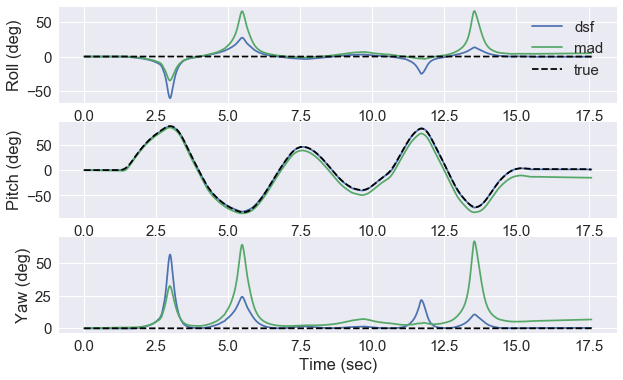

In [22]:
fig, ax = plt.subplots(3)

for orient_dsf1, orient_mad1, orient_true1, ax1 in zip(np.rollaxis(np.array(orient_dsf), 1),
                                      np.rollaxis(orient_mad, 1),
                                      np.rollaxis(orient_true, 1), ax):
    ax1.plot(t, np.rad2deg(np.array(orient_dsf1)), label='dsf')
    ax1.plot(t, np.rad2deg(np.array(orient_mad1)), label='mad')
    ax1.plot(t, np.rad2deg(np.array(orient_true1)), 'k--', label='true')

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Roll (deg)')
ax[1].set_ylabel('Pitch (deg)')
ax[2].set_ylabel('Yaw (deg)')

ax[2].set_xlabel('Time (sec)')

plt.show()

Note that the apparent errors in roll and yaw are due to being close to the Euler angle singularity, not true errors

The orientation error consists of two components: the error estimating the world's z axis (gravity) in the chip's coordinate system, and the error estimating the orientation in the plane perpendicular to gravity.  For the second error, we'll use the error estimating the world's x axis.  The z error should be small and tend toward zero, because we have a good measurement of gravity from the accelerometer.  The x error will tend to diverge over time for any algorithm, because we don't have any way of correcting it, but we hope that the divergence should be slow.

In [23]:
z_chip_dsf = np.array([np.array([0, 0, 1.0]).dot(o1).dot(world_basis) for o1 in orient_dsf_rotm])
z_chip_mad = np.array([np.array([0, 0, 1.0]).dot(o1).dot(world_basis) for o1 in orient_mad_rotm])
z_chip_true = np.array([np.array([0, 0, 1.0]).dot(o1).dot(world_basis) for o1 in orient_true_rotm])

x_chip_dsf = np.array([np.array([1.0, 0, 0]).dot(o1).dot(world_basis) for o1 in orient_dsf_rotm])
x_chip_mad = np.array([np.array([1.0, 0, 0]).dot(o1).dot(world_basis) for o1 in orient_mad_rotm])
x_chip_true = np.array([np.array([1.0, 0, 0]).dot(o1).dot(world_basis) for o1 in orient_true_rotm])

z_err_dsf = np.array([np.arccos(z_true1.dot(z_dsf1)) for z_true1, z_dsf1 in zip(z_chip_true, z_chip_dsf)])
z_err_mad = np.array([np.arccos(z_true1.dot(z_mad1)) for z_true1, z_mad1 in zip(z_chip_true, z_chip_mad)])

x_err_dsf = np.array([np.arccos(x_true1.dot(x_dsf1)) for x_true1, x_dsf1 in zip(x_chip_true, x_chip_dsf)])
x_err_mad = np.array([np.arccos(x_true1.dot(x_mad1)) for x_true1, x_mad1 in zip(x_chip_true, x_chip_mad)])

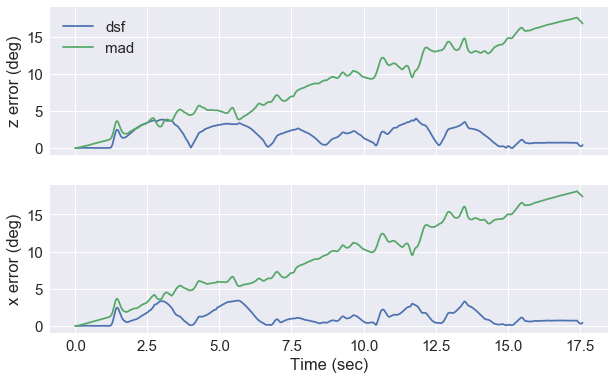

In [24]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].plot(t, np.rad2deg(z_err_dsf), label='dsf')
ax[0].plot(t, np.rad2deg(z_err_mad), label='mad')
ax[0].set_ylabel('z error (deg)')
ax[0].legend()

ax[1].plot(t, np.rad2deg(x_err_dsf), label='dsf')
ax[1].plot(t, np.rad2deg(x_err_mad), label='mad')
ax[1].set_ylabel('x error (deg)')
ax[1].set_xlabel('Time (sec)')

plt.show()

## Check the dynamic acceleration estimation

Get the angular velocity omega and acceleration omega_dot from the known orientation

In [25]:
omega_world_true = -np.gradient(orient_true, dt, axis=0)
omega_dot_world_true = np.gradient(omega_world_true, dt, axis=0)

omega_chip_true = world_basis.T.dot(omega_world_true.T).T

Compare to the chip's measured angular velocities

In [26]:
omega = np.array(data.as_list_of_triples(0, 'gyro'))
omega_dot = np.gradient(omega, dt, axis=0)

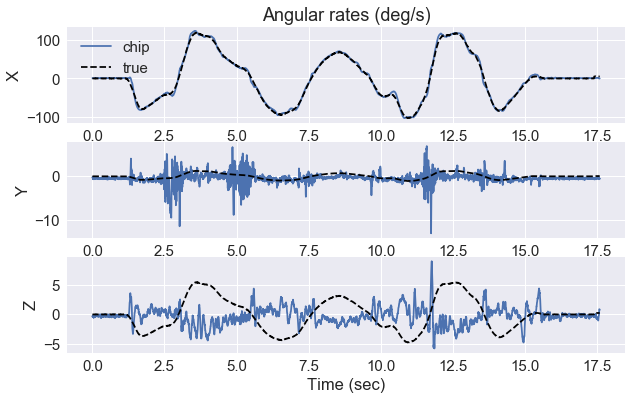

In [27]:
fig, ax = plt.subplots(3)

for omega1, omega_true1, ax1 in zip(np.rollaxis(omega, 1), np.rollaxis(omega_chip_true, 1), ax):
    ax1.plot(t, np.rad2deg(omega1), label='chip')
    ax1.plot(t, np.rad2deg(omega_true1), 'k--', label='true')
    
ax[0].set_title('Angular rates (deg/s)')
ax[0].set_ylabel('X')
ax[0].legend()

ax[1].set_ylabel('Y')
ax[2].set_ylabel('Z')
ax[2].set_xlabel('Time (sec)')

plt.show()

Now compute the true dynamic acceleration.  Dynamic acceleration includes the angular component, due to angular acceleration, and the centripetal component, directed outward along the arm, plus the actual dynamic acceleration of the center of mass.

xpb is the position of the chip on the arm, relative to the base

In [28]:
armlen = 0.5    # meters
xpb_world = np.array([0, 0, armlen])
xpb_chip = world_basis.T.dot(xpb_world)

In [29]:
acc_base = np.array([base_basis.dot(acc1) - np.array([0, 0, 9.81]) for acc1 in data.as_list_of_triples(1, 'accel')])

In [30]:
acc_angular_true = np.cross(omega_dot_world_true, xpb_world)
acc_centrip_true = np.cross(omega_world_true, np.cross(omega_world_true, xpb_world))
acc_dyn_true = acc_angular_true + acc_centrip_true + acc_base

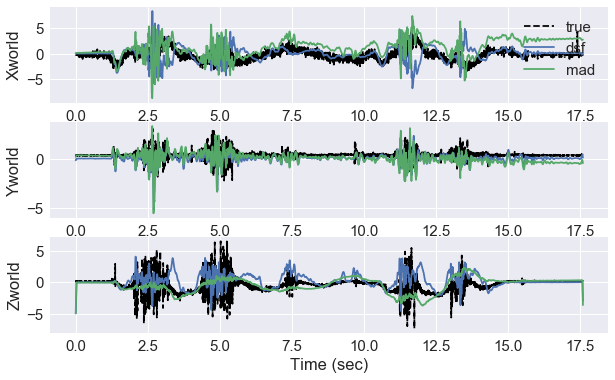

In [31]:
fig, ax = plt.subplots(3)

for acc_dsf1, acc_mad1, acc_true1, ax1 in zip(np.rollaxis(np.array(accdyn_dsf), 1), np.rollaxis(accdyn_mad, 1), 
                                              np.rollaxis(acc_dyn_true, 1), ax):
    ax1.plot(t, np.array(acc_true1), 'k--', label='true')
    ax1.plot(t, np.array(acc_dsf1), label='dsf')
    ax1.plot(t, np.array(acc_mad1), label='mad')

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Xworld')
ax[1].set_ylabel('Yworld')
ax[2].set_ylabel('Zworld')

ax[2].set_xlabel('Time (sec)')

plt.show()

Acceleration error is just the magnitude of the vector difference between the estimated acceleration and the true acceleration.

In [32]:
acc_err_dsf = np.array([np.linalg.norm(acc_true1 - acc_dsf1) for acc_true1, acc_dsf1 in zip(acc_dyn_true, accdyn_dsf)])
acc_err_mad = np.array([np.linalg.norm(acc_true1 - acc_mad1) for acc_true1, acc_mad1 in zip(acc_dyn_true, accdyn_mad)])

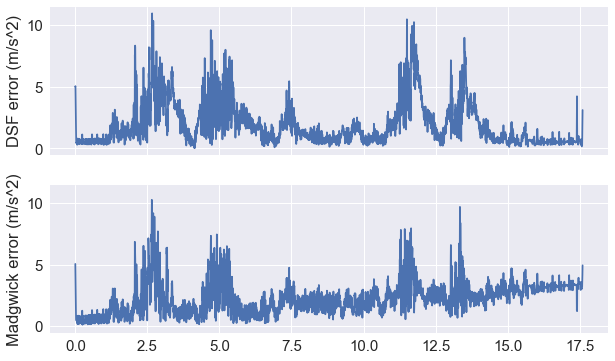

In [33]:
fig, ax = plt.subplots(2, sharex=True, sharey=True)

ax[0].plot(t, acc_err_dsf)
ax[0].set_ylabel('DSF error (m/s^2)')
ax[1].plot(t, acc_err_mad)
ax[1].set_ylabel('Madgwick error (m/s^2)')

plt.show()

If we know the distance of the accelerometer from the true center of mass, we can estimate the dynamic acceleration based on the chip's angular velocity and angular acceleration, just like we did from the arm.  Compare the true dynamic acceleration components to those estimated from the gyro

Get the gyro reading and take the derivative to get angular acceleration

In [34]:
omega = np.array(data.as_list_of_triples(0, 'gyro'))
omega_dot = np.gradient(omega, dt, axis=0)

In [35]:
acc_angular = world_basis.dot(np.cross(omega_dot, xpb_chip).T).T
acc_centrip = world_basis.dot(np.cross(omega, np.cross(omega, xpb_chip)).T).T

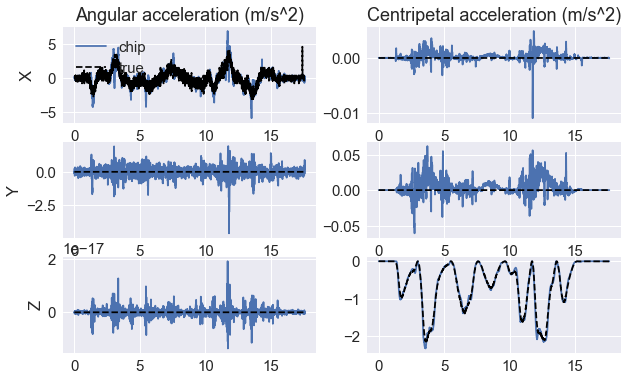

In [36]:
fig, ax = plt.subplots(3,2)

for angular1, centrip1, angular_true1, centrip_true1, ax1 in zip(np.rollaxis(acc_angular, 1), np.rollaxis(acc_centrip, 1), 
                                  np.rollaxis(acc_angular_true, 1), np.rollaxis(acc_centrip_true, 1), ax):
    ax1[0].plot(t, angular1, label='chip')
    ax1[0].plot(t, angular_true1, 'k--', label='true')
    ax1[1].plot(t, centrip1, label='chip')
    ax1[1].plot(t, centrip_true1, 'k--', label='true')

ax[0, 0].set_title('Angular acceleration (m/s^2)')
ax[0, 1].set_title('Centripetal acceleration (m/s^2)')
ax[0, 0].set_ylabel('X')
ax[1, 0].set_ylabel('Y')
ax[2, 0].set_ylabel('Z')
ax[0, 0].legend()

plt.show()

# Compare the different cases

In [37]:
data_rot = Ic_data()
data_rot.load_hdf5_file('/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_only.hdf5')

data_trans = Ic_data()
data_trans.load_hdf5_file('/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/translate_only.hdf5')

data_trans_rot = Ic_data()
data_trans_rot.load_hdf5_file('/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_and_translate2.hdf5')

data_all = [data_rot, data_trans, data_trans_rot]
data_names = ['rotate', 'translate', 'rot + trans']

DEBUG:root:datafile: /data/ KeysView(<HDF5 file "rotate_only.hdf5" (mode r)>)


DEBUG:root:Loaded 2 IMUs


DEBUG:root:datafile: /data/ KeysView(<HDF5 file "translate_only.hdf5" (mode r)>)


DEBUG:root:Loaded 2 IMUs


DEBUG:root:datafile: /data/ KeysView(<HDF5 file "rotate_and_translate2.hdf5" (mode r)>)


DEBUG:root:Loaded 2 IMUs


Get initial chip orientation in each case

In [38]:
acc = []
t = []
dt = []
initial_gravity = []

for data1 in data_all:
    acc1 = np.array(data1.as_list_of_triples(0, 'accel'))
    t1 = np.array(data1.imu_data['timestamps'])/timescale
    dt.append(np.mean(np.diff(t1)))

    initial_gravity.append(np.mean(acc1[t1 < 0.2, :], axis=0))
    
    acc.append(acc1)
    t.append(t1)

In [40]:
process = Ic_process()

accdyn = []
orient = []
rotm = []
for data1, grav1 in zip(data_all, initial_gravity):
    accdyn1, orient1, rotm1 = process.get_orientation_dsf(0, grav1, 
                                                          np.array(basis_vector).T,
                                                          still_accel, still_gyro, 
                                                          data1, 10)
    accdyn2, orient2, rotm2 = process.get_orientation_madgwick(np.array(basis_vector).T,
                                                               data1, 10,
                                                               beta=beta)
    accdyn.append({'dsf': np.array(accdyn1), 'madgwick': np.array(accdyn2)})
    orient.append({'dsf': np.array(orient1), 'madgwick': np.array(orient2)})
    rotm.append({'dsf': np.array(rotm1), 'madgwick': np.array(rotm2)})

In [41]:
orient_true = []
rotm_true = []
accdyn_true = []
for data1, dt1 in zip(data_all, dt):
    enc1 = np.deg2rad(np.array(data1.imu_data['encoder']))
    
    orient_true1 = np.zeros((len(enc1), 3))
    orient_true1[:, 1] = enc1 - enc1[0]
    orient_true1[:, 1] = np.convolve(orient_true1[:, 1], np.ones((80,))/80, mode='same')
    
    orient_true.append(orient_true1)
    rotm_true.append(np.array([process._eul2rotm(o1).T for o1 in orient_true1]))
    
    omega_world_true1 = -np.gradient(orient_true1, dt1, axis=0)
    omega_dot_world_true1 = np.gradient(omega_world_true1, dt1, axis=0)
    
    acc_base = np.array([base_basis.dot(acc1) - np.array([0, 0, 9.81]) for acc1 in data1.as_list_of_triples(1, 'accel')])
    
    acc_angular_true = np.cross(omega_dot_world_true1, xpb_world)
    acc_centrip_true = np.cross(omega_world_true1, np.cross(omega_world_true1, xpb_world))
    accdyn_true.append(acc_angular_true + acc_centrip_true + acc_base)

In [42]:
z_err = []
y_err = []

for R, Rtrue in zip(rotm, rotm_true):
    z_chip_true1 = np.array([np.array([0, 0, 1.0]).dot(o1).dot(world_basis) for o1 in Rtrue])
    y_chip_true1 = np.array([np.array([0, 1.0, 0]).dot(o1).dot(world_basis) for o1 in Rtrue])

    z_err1 = {}
    y_err1 = {}
    for method, R1 in R.items():
        z_chip1 = np.array([np.array([0, 0, 1.0]).dot(o1).dot(world_basis) for o1 in R1])
        z_err1[method] = np.array([np.arccos(z_true1.dot(z1)) for z_true1, z1 in zip(z_chip_true1, z_chip1)])
        
        y_chip1 = np.array([np.array([0, 1.0, 0]).dot(o1).dot(world_basis) for o1 in R1])
        y_err1[method] = np.array([np.arccos(y_true1.dot(y1)) for y_true1, y1 in zip(y_chip_true1, y_chip1)])        

    z_err.append(z_err1)
    y_err.append(y_err1)

/Users/etytel01/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app


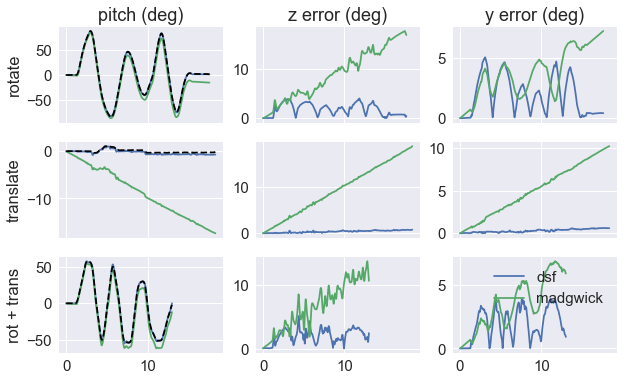

In [43]:
fig, ax = plt.subplots(len(orient), 3, sharex=True)

for t1, o1, otrue1, z_err1, y_err1, ax1, name1 in zip(t, orient, orient_true, 
                                                       z_err, y_err,
                                                       ax, data_names):
    for method, val in o1.items():
        ax1[0].plot(t1, np.rad2deg(val[:, 1]), label=method)
        ax1[1].plot(t1, np.rad2deg(z_err1[method]), label=method)
        ax1[2].plot(t1, np.rad2deg(y_err1[method]), label=method)
        
    ax1[0].plot(t1, np.rad2deg(otrue1[:, 1]), 'k--', label='true')
    
    ax1[0].set_ylabel(name1)
    
ax[0, 0].set_title('pitch (deg)')
ax[0, 1].set_title('z error (deg)')
ax[0, 2].set_title('y error (deg)')
ax[2, 2].legend()
plt.show()

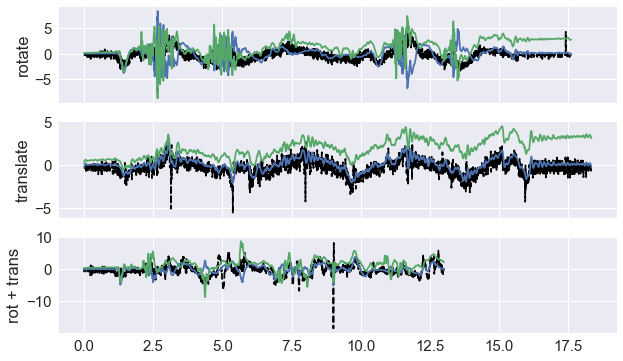

In [44]:
fig, ax = plt.subplots(len(accdyn), 1, sharex=True)

for t1, a1, atrue1, ax1, name1 in zip(t, accdyn, accdyn_true, ax, data_names):
    ax1.plot(t1, atrue1[:, 0], 'k--', label='true')
    for method in a1.keys():
        ax1.plot(t1, a1[method][:, 0], label=method)
    ax1.set_ylabel(name1)

plt.show()

In [45]:
accdyn_err = []

for a1, atrue1 in zip(accdyn, accdyn_true):
    aerr1 = {}
    for method in a1.keys():
        aerr1[method] = np.array([np.linalg.norm(atrue11 - a11) for atrue11, a11 in zip(atrue1, a1[method])])
    accdyn_err.append(aerr1)

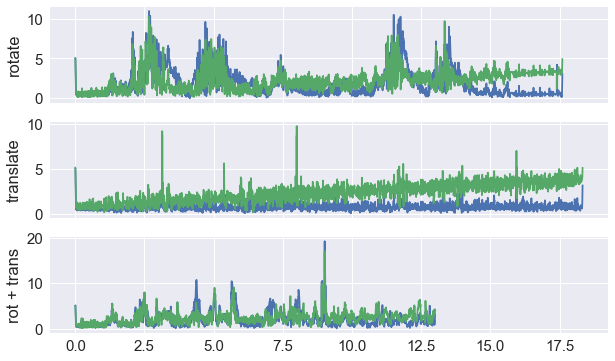

In [46]:
fig, ax = plt.subplots(len(accdyn), 1, sharex=True)

for t1, aerr1, ax1, name1 in zip(t, accdyn_err, ax, data_names):
    for method in aerr1.keys():
        ax1.plot(t1, aerr1[method], label=method)
    ax1.set_ylabel(name1)

plt.show()